Notes from the [Deep Learning Book](https://www.deeplearningbook.org/)

In [1]:
%pylab inline
import torch
import torch.nn.functional as F
import numpy as np
dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

Populating the interactive namespace from numpy and matplotlib


## Ch. 6  Deep Feedforward Networks 

$$\renewcommand\vec{\boldsymbol}$$

The goal of a feedforward network is to approximate some function $f^*$. For example, for a classifier, $y = f^*(\vec {x})$ maps an input $\vec x$ to a category $y$. A feedforward neural network defines a mapping $y = f(\vec x; \vec{\theta})$ and learns the value of the parameters $\theta$ that result in the "best" function approximation.



### 6.1 Example: Learning XOR

We specify our complete network as 

$$f(\vec x; \vec w , \vec c, \vec{\omega}, b) = \vec \omega^T \max\{0, \vec w^T \vec x + \vec c\} + b$$

In [2]:
torch.manual_seed(779)
x = torch.tensor([[0,0,1],[0,1,1],[1,0,1],[1,1,1]], device=device, dtype = dtype) #added bias
y = torch.tensor([[0],[1],[1],[0]], device=device, dtype = dtype)

w1 = torch.randn(3,2, device=device, dtype = dtype, requires_grad=True)
w2 = torch.randn(3,1, device=device, dtype = dtype, requires_grad=True)

bias = torch.ones(4,1, device=device, dtype = dtype)

learning_rate = 1e-3
for t in range(10000):
    
    hidden_out = x.mm(w1).clamp(min=0)
    z = torch.cat((hidden_out, bias), 1)
    y_pred = z.mm(w2)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum()
    if t%1000 == 0: 
        print t, loss.item()

    # Use autograd to compute the backward pass.
    loss.backward()

    # Update weights using gradient descent
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        # Manually zero the gradients after updating weights
        w1.grad.zero_()
        w2.grad.zero_()

0 2.31601905823
1000 0.976587891579
2000 0.75564545393
3000 0.398879617453
4000 0.142028912902
5000 0.0392220430076
6000 0.00873885676265
7000 0.00173346407246
8000 0.000325093918946
9000 5.94958692091e-05


In [3]:
bias = torch.ones(4,1, device=device, dtype = dtype)
hidden_out = x.mm(w1).clamp(min=0)
z = torch.cat((hidden_out, bias), 1)
z.mm(w2)

tensor([[0.0009],
        [0.9983],
        [0.9983],
        [0.0021]], grad_fn=<MmBackward>)

#### Stochastic gradient descent applied to nonconvex loss funtions has no convergence guarantee and is sensitive to the values of the initial parameters.

In [4]:
torch.manual_seed(772) # fail

class NeuralNet(torch.nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.W1 = torch.nn.Linear(2, 4)
        self.W2 = torch.nn.Linear(4, 1)

    def forward(self, x):
        h = F.relu(self.W1(x))
        y = self.W2(h)
        return y

x = torch.FloatTensor([[0,0], [0,1], [1,0], [1,1]])
y = torch.FloatTensor([[0,1,1,0]])


net = NeuralNet()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

for i in range(5000):
    net.zero_grad()
    preds = net(x)
    loss = loss_fn(preds, y.t())
    loss.backward()
    if i%1000 == 0: 
        print i, loss.item()
    optimizer.step()


0 0.286532461643
1000 0.125090390444
2000 0.125
3000 0.125
4000 0.125


### 6.2.1 Cost Functions

An important aspect of the design of a deep neural network is the choice of the cost function. In most cases, our parametric model defines a distribution $p(\vec y | \vec x ; \vec \theta)$ and we simply use the principle of maximum likelihood. This means we use the cross-entropy between the training data and the model's predictions as the cost function. This cost function is given by 

$$J(\vec \theta) = - \mathbb{E}_{\vec x, \vec y \sim \hat p_{data}} \log p_{model} (\vec y ~ | ~ \vec x)$$

The specific form of the cost function changes from model to model, for example, if $p_{model}(\vec y ~ | ~ \vec x) = N (\vec y ; f(\vec x ; \vec{\theta} ), \mathbf{I})$, then we recover the mean squared error cost:

$$J(\vec \theta) = \frac 1 2 \mathbb{E}_{\vec x, \vec y \sim \hat p_{data}} \parallel \vec y - f(\vec x ; \vec{\theta}) \parallel^2 + \text{const.} $$

up to a scaling factor of one half and a term that does not depend on $\vec \theta$. The discarded constant is based on the variance of the Gaussian distribution, which in this case we chose not to parametrize.

An advantage of this approach of deriving the cost function from maximum likelihood is that it removes the burden of designing cost functions for each model. Specifying a model $p_{model}(\vec y | \vec x)$ automatically determines a cost function.

### 6.2.2 Output Units

The choice of cost function is tightly coupled with the choice of output unit. 

#### Linear Units for Gaussian Output Distributions

One simple kind of output unit is based on an affine transformation (I believe that's just a fancy way to say linear). These are often just called linear units. 

Given features $h$, a layer of linear output units produces a vector $\hat {\vec y} = \vec W^T \vec h + \vec b$.

Linear output layers are often used to produce the mean of a conditional Gaussian distribution:

$$p(\vec y ~ | ~ \vec x) = N (\vec y ; \hat {\vec y}, \mathbf{I})$$

Maximizing the log-likelihood is then equivalent to minimizing the mean squared error.



[[5.26991056]
 [8.75019567]
 [5.30521014]
 [0.4949382 ]] 
[[ 7.41846355]
 [11.51277191]
 [ 9.31349201]
 [ 2.94719591]]


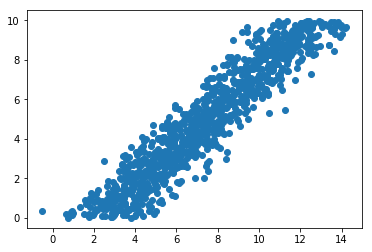

In [28]:
x = 10*np.random.rand(1000,1)
y = x + np.random.randn(1000,1) + 2.5
print x[:4],"\n", y[:4]
scatter(y[:,0], x[:,0]);

In [47]:
torch.manual_seed(77)

model = torch.nn.Sequential(
    torch.nn.Linear(1,1),
)
x = torch.tensor(x, device=device, dtype = dtype)
y = torch.tensor(y, device=device, dtype = dtype)
loss_fn = torch.nn.MSELoss(reduction='sum')

optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
for t in range(1000):

    y_pred = model(x)

    loss = loss_fn(y_pred, y)
    if t%50 == 0:
        print t, loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()
    
print "weights: ",
for param in model.parameters():
    print param.data.item(), 
print 
for name, p in model.named_parameters():
    print name
    print p


0 116148.25
50 2083.77978516
100 1669.56066895
150 1418.1439209
200 1265.54260254
250 1172.91894531
300 1116.69958496
350 1082.57653809
400 1061.86499023
450 1049.29382324
500 1041.66357422
550 1037.03222656
600 1034.22119141
650 1032.51501465
700 1031.47937012
750 1030.85083008
800 1030.46923828
850 1030.2376709
900 1030.09716797
950 1030.01171875
weights:  1.00798821449 2.44054055214
0.weight
Parameter containing:
tensor([[1.0080]], requires_grad=True)
0.bias
Parameter containing:
tensor([2.4405], requires_grad=True)


In [41]:
torch.manual_seed(77)

model = torch.nn.Sequential(
    torch.nn.Linear(1,1),
)
x = torch.tensor(x, device=device, dtype = dtype)
y = torch.tensor(y, device=device, dtype = dtype)


optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
for t in range(1000):

    y_pred = model(x)

    loss = torch.pow(y_pred - y, 2).sum()
    if t%50 == 0:
        print t, loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()
    
model(torch.tensor(np.array([[0,1,2,3,4,5,6,7,8,9,10]]).T, device=device, dtype = dtype))

0 116148.25
50 2083.77954102
100 1669.56054688
150 1418.1439209
200 1265.54260254
250 1172.91906738
300 1116.69946289
350 1082.57666016
400 1061.86523438
450 1049.29394531
500 1041.66357422
550 1037.03234863
600 1034.22119141
650 1032.51501465
700 1031.47924805
750 1030.85083008
800 1030.46936035
850 1030.23754883
900 1030.09729004
950 1030.01171875


tensor([[ 2.4405],
        [ 3.4485],
        [ 4.4565],
        [ 5.4645],
        [ 6.4725],
        [ 7.4805],
        [ 8.4885],
        [ 9.4965],
        [10.5044],
        [11.5124],
        [12.5204]], grad_fn=<ThAddmmBackward>)

#### Sigmoid Units for Bernoulli Output Distributions

Many tasks require predicting the value of a binary variable $y$.

The maximum likelihood approach is to define a Bernoulli distribution over $y$ conditioned on $\vec x$.

A Bernoulli distribution is defined by just a single number. The neural net needs to predict only $\mathbb{P}(y = 1 ~ | ~ \vec x)$. For this number to be a valid probability, it must lie in the interval [0,1].

We use an approach based on using sigmoid output units combined with maximum likelihood.

A sigmoid output unit is defined by

$$\hat y = \sigma \left( {\vec w}^T \vec h + b \right)$$

where

$$\sigma(x) \equiv \frac 1 {1 + \exp(-x)} $$

The book seems a little too much at this derivation, so switching to this [explanation](https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html) for the next derivations.


... Well, on second thought, maybe, I'll just post my own derivation. This is distantly based on [this](http://neuralnetworksanddeeplearning.com/chap3.html) which makes very good reading.

So, we are naturally looking at the Bernoulli distribution, which has the p.m.f.:

$$f(y;p) = p^y (1-p)^{1-y}$$

Therefore the Likelihood function is

$$L(p) = \prod_{i=1}^n p^{y_i} (1-p)^{(1-y_i)}$$

and the log-likelihood is therefore

$$ l(p) = \sum_{i=1}^n [y_i \ln p + (1-y_i) \ln (1-p)]$$

which we seek to maximize. Or, we can minimize the negative of the above to work with the built in optimizers.

[Parameter containing:
tensor([[0.8234, 0.9572]], requires_grad=True), Parameter containing:
tensor([0.0939], requires_grad=True)]


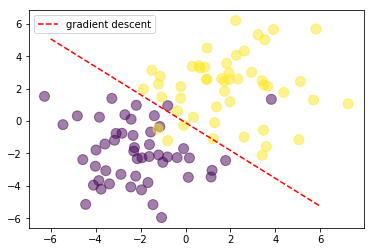

In [7]:
#Based off
#https://m-alcu.github.io/blog/2018/02/10/logit-pytorch/

N = 100
D = 2
np.random.seed(77)
torch.manual_seed(77) 
x = np.random.randn(N,D)*2
x[:N/2,:] = x[:N/2,:] - 2*np.ones((N/2,D))
x[N/2:,:] = x[N/2:,:] + 2*np.ones((N/2,D))

# labels: first N/2 are 0, last N/2 are 1
y = np.array([0]*(N/2) + [1]*(N/2)).reshape(100,1)

model = torch.nn.Sequential(
    torch.nn.Linear(2,1),
    torch.nn.Sigmoid()
)

x = torch.tensor(x, device=device, dtype = dtype)
y = torch.tensor(y, device=device, dtype = dtype)


optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
for t in range(10000):
    y_pred = model(x)

    #Take the error when label=1
    class1_cost = -y*torch.log(y_pred)

    #Take the error when label=0
    class2_cost = (1-y)*torch.log(1-y_pred)

    #Take the sum of both costs
    loss = (class1_cost - class2_cost).sum()
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
w = list(model.parameters())
w0 = w[0].data.numpy()
w1 = w[1].data.numpy()
print w
# plot the data and separating line
plt.scatter(x[:,0], x[:,1], c=y.reshape(N), s=100, alpha=0.5)
x_axis = np.linspace(-6, 6, 100)
y_axis = -(w1[0] + x_axis*w0[0][0]) / w0[0][1]
line_up, = plt.plot(x_axis, y_axis,'r--', label='gradient descent')
plt.legend(handles=[line_up])

plt.show();

[Parameter containing:
tensor([[0.8234, 0.9572]], requires_grad=True), Parameter containing:
tensor([0.0939], requires_grad=True)]


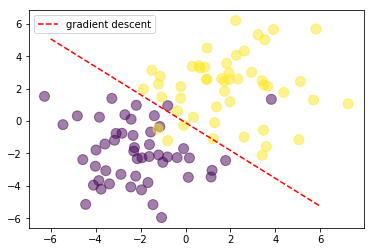

In [8]:
torch.manual_seed(77) 

model = torch.nn.Sequential(
    torch.nn.Linear(2,1),
    torch.nn.Sigmoid()
)


criterion = torch.nn.BCELoss(reduction="sum")
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
for t in range(10000):
    y_pred = model(x)
    print y_pred
    loss = criterion(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
w = list(model.parameters())
w0 = w[0].data.numpy()
w1 = w[1].data.numpy()
print w
# plot the data and separating line
plt.scatter(x[:,0], x[:,1], c=y.reshape(N), s=100, alpha=0.5)
x_axis = np.linspace(-6, 6, 100)
y_axis = -(w1[0] + x_axis*w0[0][0]) / w0[0][1]
line_up, = plt.plot(x_axis, y_axis,'r--', label='gradient descent')
plt.legend(handles=[line_up])

plt.show();

####  Softmax Units for Multinoulli Distributions

Any time we wish to represent a probability distribution over a discrete variable with K possible values, we may wish to use the softmax function:

$$y_i(z) = \text{softmax}(z)_i = \frac {\exp (z_i)}{\sum_{k=1}^K \exp (z_k)}$$

Taking the calculations from [Bishop](https://www.springer.com/us/book/9780387310732), we next write down the likelihood function:

$$L = \prod_{n=1}^N \prod_{k=1}^K y_k^{t_{nk}}(z_n)$$

Where $t_{nk}$ has the obvious interpretation as a binary vector with all elements zero except for element k. And the product over n, is for the N example target/feature examples (must be an easier way to say this).

And we easily write the log likelihood as

$$l = \sum_{n=1}^N \sum_{k=1}^K t_{nk} \ln y_k(z_n)$$

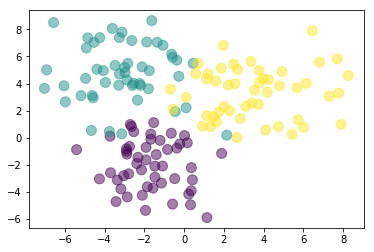

In [9]:
N = 150
D = 2
np.random.seed(71)

x = np.random.randn(N,D)*2
x[:N/3,:] = x[:N/3,:] - 2*np.ones((N/3,D))
x[N/3:2*N/3,:] = x[N/3:2*N/3,:] + 2*np.array([-1.5,2.5]*(N/3)).reshape(50,2)
x[2*N/3:,:] = x[2*N/3:,:] + 3*np.ones((N/3,D))

# labels: first N/2 are 0, last N/2 are 1
y = np.array([0]*(N/3) + [1]*(N/3) +[2]*(N/3) ).reshape(150,1)
plt.scatter(x[:,0], x[:,1], c=y.reshape(N), s=100, alpha=0.5)

plt.show();

In [24]:
torch.manual_seed(73)

model = torch.nn.Sequential(
    torch.nn.Linear(2,3),
    torch.nn.Softmax(dim=1)
)

x = torch.tensor(x, device=device, dtype = dtype)
y = torch.tensor(y, device=device, dtype = torch.int64).squeeze_()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
for t in range(100):
    y_pred = model(x)

    loss = -torch.log(y_pred[np.arange(len(y)), y]).sum()

    if t%10 == 0: 
        print t, loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


0 464.329956055
10 31.0559120178
20 26.4215545654
30 23.7159633636
40 22.5643672943
50 22.1209640503
60 21.9265823364
70 21.8176460266
80 21.7451076508
90 21.6930236816


In [25]:
torch.manual_seed(73)

model = torch.nn.Sequential(
    torch.nn.Linear(2,3),
    torch.nn.LogSoftmax(dim=1)
)

x = torch.tensor(x, device=device, dtype = dtype)
y = torch.tensor(y, device=device, dtype = torch.int64).squeeze_()

criterion = torch.nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
for t in range(100):
    y_pred = model(x)

    loss = criterion(y_pred, y) 
    if t%10 == 0: 
        print t, loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   

0 464.329956055
10 31.0559062958
20 26.4215526581
30 23.7159519196
40 22.5643692017
50 22.1209583282
60 21.9265861511
70 21.8176460266
80 21.7451038361
90 21.6930217743


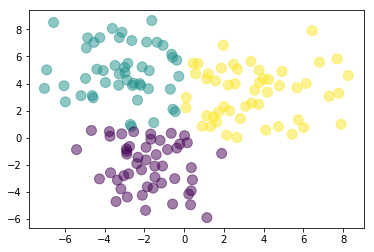

In [26]:
yy = np.argmax(y_pred.tolist(), axis = 1)
plt.scatter(x[:,0], x[:,1], c=yy.reshape(N), s=100, alpha=0.5)

plt.show();